# Foundations of Computational Economics #45

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Method of simulated moments for model estimation (MSM)

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/usZVzYanLq0](https://youtu.be/usZVzYanLq0)

Description: Using data to inform numerical economic models. Calibration and estimation of economic models. Introduction to method of simulated moments (MSM).

### What to do with numerical solutions of the economic models?

In the second half of this course we learned:

- how to write and understand Bellman equations to represent real life choice situations in an economic model  
- how to choose an appropriate solution method from the toolbox and solve the model  
- how to simulate data given the model solution  


What is the next step?

#### Once we know how to solve and simulate the model (and the code is debugged)

- study the implications of theoretical assumptions of various models and theories  
- run numerical simulations of optimal decisions and policies (for particular values or ranges of values of model parameters)  


But the **ultimate goal is to match the model to the actually observed data**, and:

- quantify of the effects of various parts of the theoretical setup  
- perform **counterfactual experiments** simulating the behavior of the decision maker in hypothetical policy regimes  
- support or falsify theoretical results by examining their fit to the observed data  

#### Structural estimation

1. Given the theoretical model of behavior, ..  
1. and its numerical implementation, ..  
1. formulate a statistical procedure (estimator) to find parameter values such that the model describes the observed data in the best possible way, and  
1. assess the variability of these values (compute standard errors of the estimates)  


*Structural estimation is the field of econometrics centered around methodological development and applications of the described approach*

#### Structural vs. reduced form econometrics

Long standing opposition, although the boundary is blurred

- Structural: theoretical model + direct estimation of parameters from the observed data  
- Reduced form: econometric model with standard assumptions + data analysis  


The fields are becoming closer: RCTs, controlled experiments, causal econometric methods (IV, regression discontinuity), applications in machine learning

#### Sources of identification of (structural) parameters of the model

1. the variation of the observed data  
1. theoretical structure of the model (assumptions on **causality** such as *exclusion restrictions*, *functional forms* and *distributional assumptions*)  


- Structural: low level assumptions informed by the economic theory  
- Reduced form: higher level assumptions informed by econometric models  


Foundation on economic theory $ \Rightarrow $ counterfactual simulations using structurally estimated model

#### Counterfactual simulations

1. Estimate the model using observed data  
1. Simulate data under status quo  
1. Change the policy environment  
1. Simulate data under alternative regime  
1. Compare to reveal the effects of the policy  
1. Perform *uncertainly quantification* to assess the variability of the results  

#### Theoretical grounds for counterfactual simulations

- uncovering deep behavioral parameters $ \rightarrow $  
- possible to assume they are not changing in policy change (policy invariant) $ \rightarrow $  
- possible to simulate decision making in a different policy environment  


*Pure data analysis is incapable of counterfactual simulations*

#### Estimation vs. calibration

What is the difference?  Sometimes the terms are used interchangeably

- **Standard errors of estimates** (measure of variability of the estimation results)  
- **Study of identification** (to make sure that other parameter values can not match the data equally well)  


Calibration exercises often skip these steps, even if employing algorithmic search of best parameters to fit the model to the data.

Applications of estimation sometimes estimate only a subset of parameters, treating other as fixed, similar to calibration with parameter values from the literature.

### Workflow of structural estimation

1. Theoretical model development (what is of interest?)  
1. Practical specification/implementation issues  
1. Solving the model (method + implementation in the code)  
1. *Understanding how the model works*  
1. Estimation: running the statistical procedure  
1. Validation (assessing out-of-sample performance)  
1. Policy experiments, counterfactual simulations  

#### Example: Stochastic consumption-savings model

1. Theoretical model: see **video 35, 39**  
1. Implementation: see **video 40, 42**  
1. Solving the model: see **video 37**  
1. **Understanding how the model works**  
1. **Estimation**  
1. Validation: *talk to me if interested*  
1. Policy experiments: *talk to me if interested*  

In [1]:
#COPY from video 42
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar, brentq

class deaton():
    '''Implementation of the stochastic Deaton consumption-savings problem with random income.'''

    def __init__(self, Mbar=10,
                 ngrid=50, nchgrid=100, nquad=10,
                 interpolation='linear', bellman_type='discretized',
                 maxiter_internal=250, tol_internal=1e-10,
                 beta=.9, R=1.05, sigma=1.):
        '''Object creator for the stochastic consumption-savings model'''
        self.beta = beta        # Discount factor
        self.R = R              # Gross interest
        self.sigma = sigma      # Param in log-normal income distribution
        self.Mbar = Mbar        # Upper bound on wealth
        self.ngrid = ngrid      # Number of grid points in the state space
        self.nchgrid = nchgrid  # Number of grid points in the decision space
        self.nquad = nquad      # Number of quadrature points
        self.interpolation = interpolation  # type of interpolation, see below
        self.bellman_type = bellman_type  # type of Bellman operator
        self.maxiter_internal = maxiter_internal  # maxiter for continuous Bellman operator
        self.tol_internal = tol_internal  # tolerance for continuous Bellman operator
        # state and choice space grids, as well as quadrature points and weights are set with setter functions below

    def __repr__(self):
        '''String representation for the model'''
        return 'Deaton model with beta={:1.3f}, sigma={:1.3f}, gross return={:1.3f}\nGrids: state {} points up to {:1.1f}, choice {} points, quadrature {} points\nInterpolation: {}\nThe model is {}solved.'\
               .format(self.beta,self.sigma,self.R,self.ngrid,self.Mbar,self.nchgrid,self.nquad,self.interpolation,'' if hasattr(self,'solution') else 'not ')

    @property
    def ngrid(self):
        '''Property getter for the ngrid parameter'''
        return self.__ngrid

    @ngrid.setter
    def ngrid(self,ngrid):
        '''Property setter for the ngrid parameter'''
        self.__ngrid = ngrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.grid = np.linspace(epsilon,self.Mbar,ngrid) # grid for state space

    @property
    def nchgrid(self):
        '''Property getter for the nchgrid parameter'''
        return self.__nchgrid

    @nchgrid.setter
    def nchgrid(self,nchgrid):
        '''Property setter for the nchgrid parameter'''
        self.__nchgrid = nchgrid
        epsilon = np.finfo(float).eps # smallest positive float number difference
        self.chgrid = np.linspace(epsilon,self.Mbar,nchgrid) # grid for state space

    @property
    def bellman_type(self):
        '''Property getter for the bellman_type parameter'''
        return self.__bellman_type

    @bellman_type.setter
    def bellman_type(self,value):
        '''Property setter for the bellman_type parameter'''
        self.__bellman_type = value
        if value == 'discretized':
            self.bellman = self.bellman_discretized
        elif value == 'continuous':
            self.bellman = self.bellman_continuous
        else:
            raise RuntimeError('Unknown Bellman type parameter')

    @property
    def sigma(self):
        '''Property getter for the sigma parameter'''
        return self.__sigma

    @sigma.setter
    def sigma(self,sigma):
        '''Property setter for the sigma parameter'''
        self.__sigma = sigma
        self.__quadrature_setup()  # update quadrature points and weights

    @property
    def nquad(self):
        '''Property getter for the number of quadrature points'''
        return self.__nquad

    @nquad.setter
    def nquad(self,nquad):
        '''Property setter for the number of quadrature points'''
        self.__nquad = nquad
        self.__quadrature_setup()  # update quadrature points and weights

    def __quadrature_setup(self):
        '''Internal function to set up quadrature points and weights,
        depends on sigma and nquad, therefore called from the property setters
        '''
        try:
            # quadrature points and weights for log-normal distribution
            self.quadp,self.quadw = np.polynomial.legendre.leggauss(self.__nquad) # Gauss-Legendre for [-1,1]
            self.quadp = (self.quadp+1)/2 # rescale to [0,1]
            self.quadp = lognorm.ppf(self.quadp,self.__sigma) # inverse cdf
            self.quadw /= 2 # rescale weights as well
        except(AttributeError):
            # when __nquad or __sigma are not yet set
            pass

    def utility(self,c):
        '''Utility function'''
        return np.log(c)

    def marginal_utility(self,c):
        '''Marginal utility function'''
        return 1/c

    def inverse_marginal_utility(self,u):
        '''Marginal utility function'''
        return 1/u

    def next_period_wealth(self,M,c,y):
        '''Next period budget'''
        if self.nquad>1:
            return self.R*(M-c) + y  # next period wealth
        else:
            return self.R*(M-c) + np.zeros(shape=y.shape) # next period wealth without income

    def interp_func(self,x,f):
        '''Returns the interpolation function for given data'''
        if self.interpolation=='linear':
            return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            return interpolate.interp1d(x,f,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            return interpolate.interp1d(x,f,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(x,f,self.ngrid_state-1)
            return lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None

    def bellman_discretized(self,V0):
        '''Bellman operator with discretized choice,
           V0 is 1-dim vector of values on the state grid
        '''
        c = self.chgrid[:,np.newaxis,np.newaxis]   # axis 0: choices
        M = self.grid[np.newaxis,:,np.newaxis]     # axis 1: states
        y = self.quadp[np.newaxis,np.newaxis,:]    # axis 2: quadrature points
        c = c.repeat(self.ngrid,axis=1).repeat(self.nquad,axis=2)  # 3-dim array of choices
        c *= M/self.Mbar                           # scale values of choices to ensure c<=M
        M1 = self.next_period_wealth(M,c,y)        # 3-dim array with quad point in last dimension
        inter = self.interp_func(self.grid,V0)            # interpolating function for next period value function
        V1 = inter(M1)                                    # value function at next period wealth, 3-dim array
        EV = np.dot(V1,self.quadw)                        # expected value function, 2-dim matrix
        MX = self.utility(c[:,:,0]) + self.beta*EV        # maximand of Bellman equation, 2-dim matrix
        MX[c[:,:,0]>M[:,:,0]] = -np.inf                   # infeasible choices should have -inf (just in case)
        V1 = np.amax(MX,axis=0,keepdims=False)            # optimal choice as maximum in every column, 1-dim vector
        c1 = c[np.argmax(MX,axis=0),range(self.ngrid),0]  # choose the max attaining levels of c
        return V1, c1

    def bellman_continuous(self,V0):
        '''Bellman operator with continuous choice,
           V0 is 1-dim vector of values on the state grid
        '''
        def maximand(c,M,interf):
            '''Maximand of the Bellman equation'''
            M1 = self.next_period_wealth(M,c,self.quadp)  # vector of next period wealth
            V1 = interf(M1)                               # value function at next period wealth
            EV = np.dot(V1,self.quadw)                    # expected value function, scalar
            MX = self.utility(c) + self.beta*EV           # maximand of Bellman equation, scalar
            return -MX # negative because of minimization

        def findC(M,interf):
            '''Solves for optimal consumption for given wealth M'''
            if M<=self.grid[0]:
                return M  # return M if it is too close to zero
            opt = {'maxiter':self.maxiter_internal, 'xatol':self.tol_internal}
            res = minimize_scalar(maximand,args=(M,interf),method='Bounded',bounds=[self.grid[0],M],options=opt)
            if res.success:
                return res.x # if converged successfully
            else:
                raise RuntimeError('Bellman continuous failed to find optimal consumption')

        interfunc = self.interp_func(self.grid,V0)  # interpolation function for V0
        V1=np.empty(self.ngrid,dtype='float')    # allocate space for the policy function
        c1=np.empty(self.ngrid,dtype='float')    # allocate space for the value function
        for i,M in enumerate(self.grid):         # loop over state space
            c1[i] = findC(M,interfunc)           # find optimal consumption
            V1[i] = -maximand(c1[i],M,interfunc) # value function, don't forget the negation!
        return V1, c1

    def euler_residual(self,c,M,policy):
        '''Computes the Euler residuals for a given points (M,c), and
           given policy function that enters into the RHS
           Argument policy is interpolation function for the policy
        '''
        # assume that c and M are either scalars or 1-dim arrays of the same size
        if isinstance(c,np.ndarray):
            c0,M0 = c[:,np.newaxis],M[:,np.newaxis]  # axis 0: choices and states
            y = self.quadp[np.newaxis,:]             # axis 1: quadrature points
        else:
            c0,M0 = c,M
            y = self.quadp                           # 1-dim array of quadrature points
        M1 = self.next_period_wealth(M0,c0,y)        # 1-dim or 2-dim array with quad point in last dimension
        c1 = np.maximum(policy(M1),self.grid[0])     # value function at next period wealth, 3-dim array
        mu = self.marginal_utility(c1)               # marginal utility in the RHS
        RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
        LHS = self.marginal_utility(c)
        return LHS-RHS

    def solve_egm (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using EGM (successive approximations of efficient Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        A = np.linspace(0,self.Mbar,self.ngrid)  # grid on savings
        interp = lambda x,f: interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate") # linear interpolation
        c0 = interp([0,self.Mbar],[0,self.Mbar]) # initial policy function
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            # EGM step
            M1 = self.next_period_wealth(A[:,np.newaxis],0,self.quadp[np.newaxis,:]) # matrix with A in axis=0, y/quadpoints in axis=1
            c1 = np.maximum(c0(M1),self.grid[0])         # value function at next period wealth, 3-dim array
            mu = self.marginal_utility(c1)               # marginal utility in the RHS
            RHS = self.beta*self.R*np.dot(mu,self.quadw) # RHS of Euler equation
            c = np.empty(self.ngrid+1,dtype=float)
            M = np.empty(self.ngrid+1,dtype=float)
            c[0] = M[0] = 0.
            c[1:] = self.inverse_marginal_utility(RHS)    # current period consumption (vector)
            M[1:] = c[1:] + A                             # vector of endogenous points on M
            c1 = interp(M,c)                              # updated policy function
            c1grid = c1(self.grid)                        # vector representation of policy function
            # matrix of next period wealth, states in axis=0, quadpoint in axis=1
            M1 = self.next_period_wealth(self.grid[:,np.newaxis],c1grid[:,np.newaxis],self.quadp[np.newaxis,:])
            interfunc = self.interp_func(self.grid,V0)    # interpolcation for the value function
            V  = interfunc(M1)                            # value function at next period wealth
            EV = np.dot(V,self.quadw)                     # expected value function, vector
            V1 = self.utility(c1grid) + self.beta*EV      # maximand of Bellman equation, column-vector
            err = np.amax(np.abs(c1grid-c0(self.grid)))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1grid,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1grid,'solver':'egm'}  # save the model solution to the object
        return V1,c1grid


    def solve_timeiter (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using time iterations (successive approximations of Coleman-Reffet operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        c0 = self.grid # on first iteration assume consuming everything
        V0 = self.utility(self.grid)
        for iter in range(maxiter):
            c1 = np.empty(self.ngrid,dtype=float)  # allocate space for policy and value functions
            V1 = np.empty(self.ngrid,dtype=float)
            c0inter = self.interp_func(self.grid,c0)  # interpolation function for policy c0
            for i,M in enumerate(self.grid):
                if M<=self.grid[0] or self.euler_residual(c=M,M=M,policy=c0inter)>0:
                    c1[i] = M  # corner solution
                else:
                    c1[i] = brentq(self.euler_residual,args=(M,c0inter),a=self.grid[0],b=M,
                                  xtol=self.tol_internal,maxiter=self.maxiter_internal,
                                  full_output=False,disp=True)  # optimal consumption level for given M
                # calculation of the value function for given M and found optimal consumption c1[i]
                interfunc = self.interp_func(self.grid,V0)
                M1 = self.next_period_wealth(M,c1[i],self.quadp)  # vector of next period wealth
                V  = interfunc(M1)                                # value function at next period wealth
                EV = np.dot(V,self.quadw)                        # expected value function, scalar
                V1[i] = self.utility(c1[i]) + self.beta*EV        # maximand of Bellman equation, scalar
            err = np.amax(np.abs(c1-c0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            c0,V0 = c1,V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'time iterations'}  # save the model solution to the object
        return V1,c1

    def solve_vfi (self,maxiter=500,tol=1e-4,callback=None):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = self.utility(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1 = self.bellman(V0)
            err = np.amax(np.abs(V1-V0))
            if callback: callback(iter=iter,model=self,value=V1,policy=c1,err=err) # callback for making plots
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
        else:  # when iter went up to maxiter
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        self.solution = {'value':V1,'policy':c1,'solver':'VFI with {} Bellman'.format(self.bellman_type)}  # save the model solution to the object
        return V1,c1

    def solve_plot(self,solver,**kvarg):
        '''Illustrate solution
           Inputs: solver (string), and any inputs to the solver
        '''
        if solver=='vfi':
            solver_func = self.solve_vfi
        elif solver=='timeiter':
            solver_func = self.solve_timeiter
        elif solver=='egm':
            solver_func = self.solve_egm
        else:
            raise ValueError('Unknown solver label')
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with %s'%solver)
        ax2.set_title('Policy function convergence with %s'%solver)
        ax1.set_xlabel('Wealth, M')
        ax2.set_xlabel('Wealth, M')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(**kwargs):
            print('|',end='')
            grid = kwargs['model'].grid
            v = kwargs['value']
            c = kwargs['policy']
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = solver_func(callback=callback,**kvarg)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

    def accuracy(self,dense_grid_factor=10,verbose=False):
        '''Compute the average squared Euler residuals for the saved solution'''
        assert hasattr(self,'solution'), 'Need to solve the model to compute the accuracy measure!'
        grid = np.linspace(self.grid[0],self.Mbar,self.ngrid*dense_grid_factor) # dense grid for state space
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        c = inter(grid)  # consumption on the dense grid
        er = self.euler_residual(c=c,M=grid,policy=inter)
        er = er[np.logical_not(np.isclose(c,grid,atol=1e-10))]  # disregard corner solutions
        acc = np.mean(er**2)
        if verbose:
            print('Average squared Euler residuals ({}) using {} points is {}'.format(
                self.solution['solver'],self.ngrid*dense_grid_factor,acc))
        else:
            return acc

    def simulator(self,init_wealth=1,T=10,seed=None,plot=True):
        '''Simulation of the model for given number of periods from given initial conditions'''
        assert hasattr(self,'solution'), 'Need to solve the model before simulating!'
        if seed!=None:
            np.random.seed(seed)  # fix the seed if needed
        init_wealth = np.asarray(init_wealth).ravel()  # flat np array of initial wealth
        N = init_wealth.size  # number of trajectories to simulate
        sim = {'M':np.empty((N,T+1)),'c':np.empty((N,T+1))}
        sim['M'][:,0] = init_wealth  # initial wealth in the first column
        inter = self.interp_func(self.grid,self.solution['policy'])  # interpolation function for policy function
        for t in range(T+1):
            sim['c'][:,t] = inter(sim['M'][:,t])  # optimal consumption in period t
            if t<T:
                y = lognorm.rvs(self.sigma,size=N) # draw random income
                sim['M'][:,t+1] = self.next_period_wealth(sim['M'][:,t],sim['c'][:,t],y) # next period wealth
        if plot:
            fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
            ax1.set_title('Simulated wealth and consumption trajectories')
            ax1.set_ylabel('Wealth')
            ax2.set_ylabel('Consumption')
            ax2.set_xlabel('Time period in the simulation')
            for ax in (ax1,ax2):
                ax.grid(b=True, which='both', color='0.95', linestyle='-')
            for i in range(N):
                ax1.plot(sim['M'][i,:],alpha=0.75)
                ax2.plot(sim['c'][i,:],alpha=0.75)
            plt.show()
        return sim # return simulated data

#### Understanding how the model works — simple algorithm

1. Solve the model for a set of parameter values  
1. Simulated data from the model  
1. Does it make (economic) sense?  
1. Repeat (many-many times)  


- may take *a lot of time* to convince yourself that the code does not have bugs  
- unexpected/surprising results still appear?  Making research progress!  

C:\Users\82716\AppData\Local\Temp\ipykernel_25120\2333049099.py:375: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', color='0.95', linestyle='-')


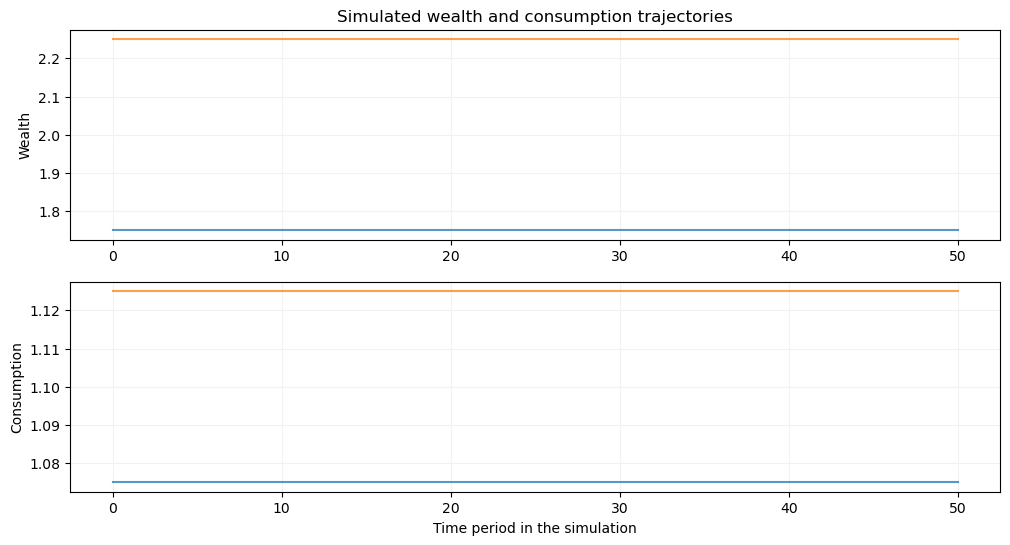

In [2]:
# deterministic model with βR=1 and y=1
m = deaton(beta=0.9,R=1/0.9,ngrid=100,nchgrid=250,sigma=1e-10,nquad=2)
m.solve_egm(tol=1e-10)
init_wealth, T = [1.75,2.25], 50
m.simulator(init_wealth=init_wealth,T=T,seed=2020)
plt.show()

C:\Users\82716\AppData\Local\Temp\ipykernel_25120\2333049099.py:375: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', color='0.95', linestyle='-')


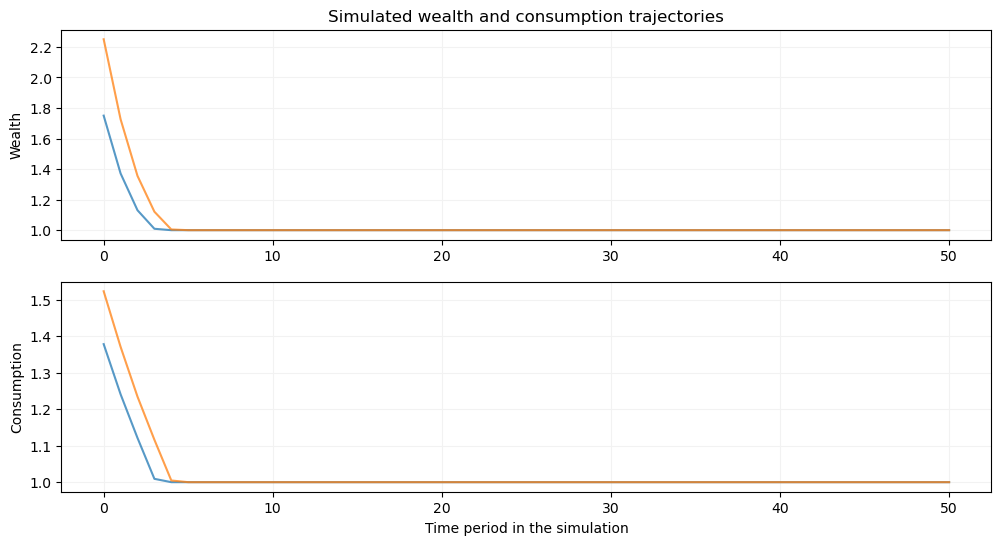

In [3]:
# deterministic model with R=1 and y=1
m = deaton(beta=0.9,R=1.0,ngrid=100,nchgrid=250,sigma=1e-10,nquad=2)
m.solve_egm(tol=1e-10)
init_wealth, T = [1.75,2.25], 50
m.simulator(init_wealth=init_wealth,T=T,seed=2020)
plt.show()

C:\Users\82716\AppData\Local\Temp\ipykernel_25120\2333049099.py:375: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', color='0.95', linestyle='-')


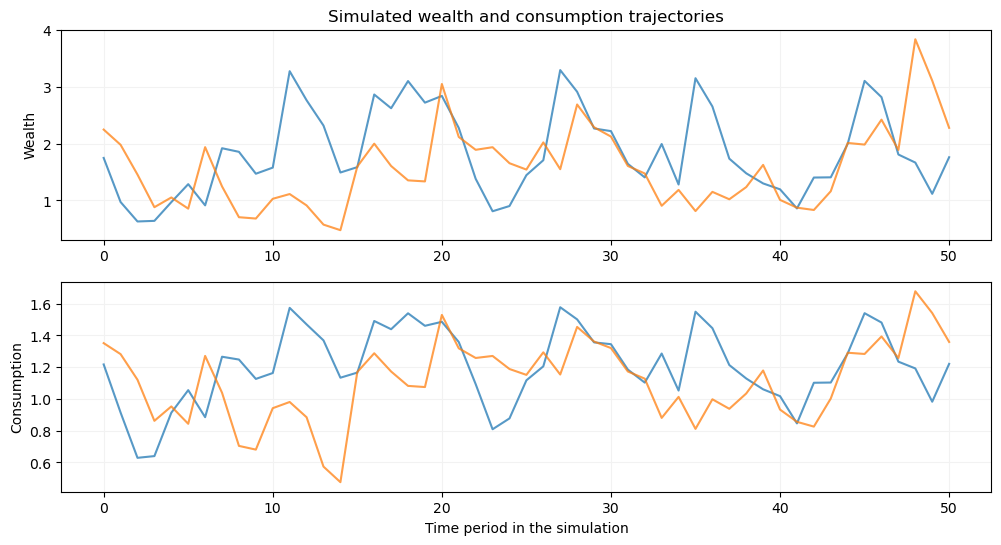

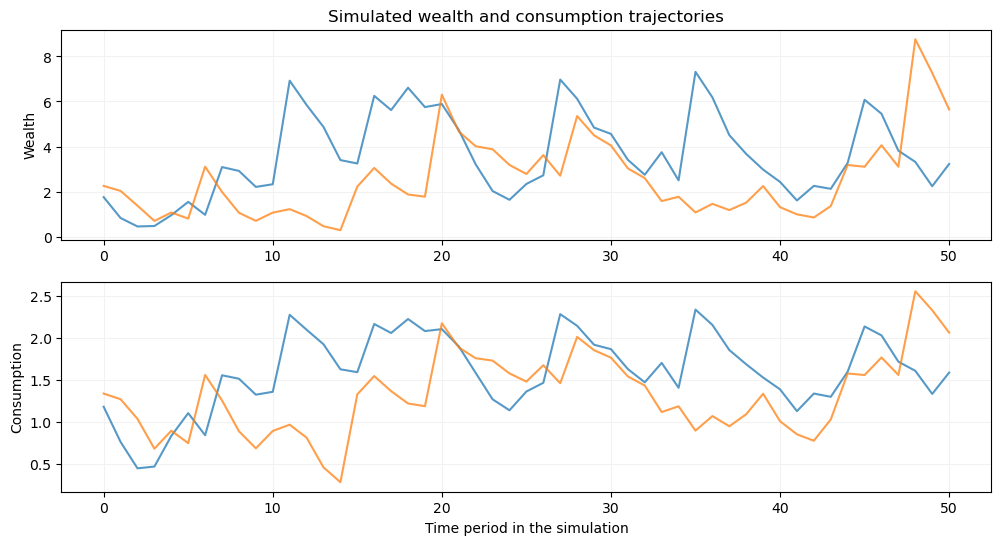

In [4]:
# two stochastic models with different income variance
m1 = deaton(beta=0.9,R=1.05,ngrid=100,nchgrid=250,sigma=0.5)
m2 = deaton(beta=0.9,R=1.05,ngrid=100,nchgrid=250,sigma=0.85)
m1.solve_egm(tol=1e-10)
m2.solve_egm(tol=1e-10)
init_wealth, T = [1.75,2.25], 50
m1.simulator(init_wealth=init_wealth,T=T,seed=2020)
m2.simulator(init_wealth=init_wealth,T=T,seed=2020)
plt.show()

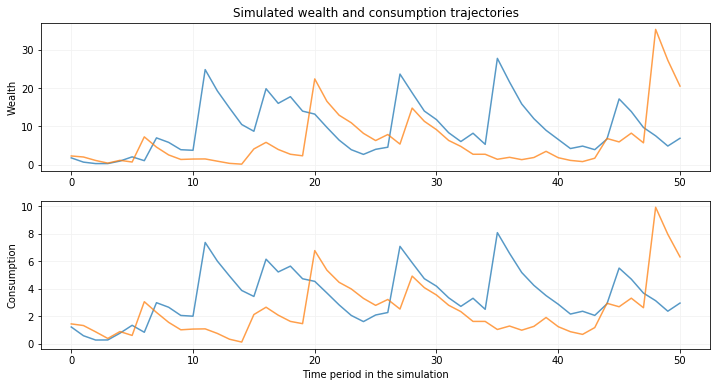

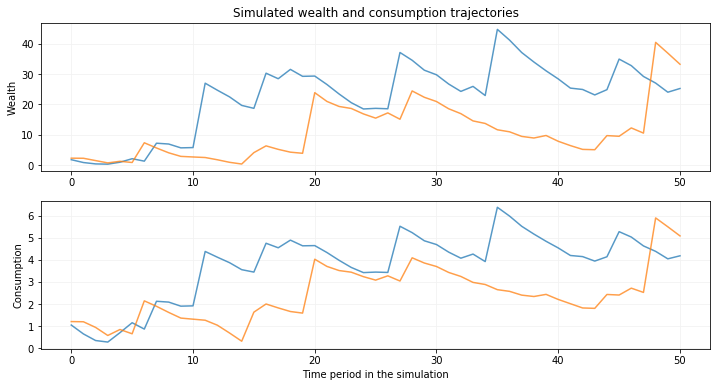

In [5]:
# two stochastic models with different dicount coefficients
m1 = deaton(beta=0.85,R=1.05,ngrid=100,nchgrid=250,sigma=1.5)
m2 = deaton(beta=0.95,R=1.05,ngrid=100,nchgrid=250,sigma=1.5)
m1.solve_egm(tol=1e-10)
m2.solve_egm(tol=1e-10)
init_wealth, T = [1.75,2.25], 50
m1.simulator(init_wealth=init_wealth,T=T,seed=2020)
m2.simulator(init_wealth=init_wealth,T=T,seed=2020)
plt.show()

### Method of simulated moments

- we have seen how changing parameters is reflected in changes in the simulated wealth and consumption profiles  
- imagine we have data on observed consumption or wealth profiles for a sample of people, or even some aggregate data on consumption or wealth  
- then we can find parameters of the model that would induce the simulated data to reflect the observed profiles, or some descriptive statistics (*moments*) of these profiles  

#### Simulated moments

The idea of *directly* matching the moments from the model to the observed ones leads to the method of moments estimator

- Method of moments: # of parameters = # of moments to match, system of equations  
- Generalized method of moments (GMM): # of parameters < # of moments, minimize the distance between the data moments and theoretical moments  
- Method of simulated moments (MSM): using simulations to compute the theoretical moments  

#### Definition of MSM estimator

$$
\hat{\theta}_{MSM}(W) = \arg\min_{\theta \in \Theta} \, e(\tilde{x},x|\theta) \, W e(\tilde{x},x|\theta)^{T}
$$

- $ \theta \in \Theta $ is parameter space  
- $ e(\tilde{x},x|\theta) $ is the row-vector of $ K $ moment conditions  
- $ W $ is the $ K \times K $ weighting matrix  
- $ x $ and $ \tilde{x} $ is observed and simulated data  

#### Moments and moment conditions

$$
e(\tilde{x},x|\theta) = \big(e^1(\tilde{x},x|\theta),\dots,e^K(\tilde{x},x|\theta) \big)
$$

$$
e^k(\tilde{x},x|\theta) = m^k(x) - m^k(\tilde{x}|\theta)
$$

- $ m^k(\cdot) $ is the $ k $-th moment generating function  
- $ m^k(x) $ are empirical moments (computed from the observed data)  
- $ m^k(\tilde{x}|\theta) $ are the simulated moments (computed from the simulated data using parameter values $ \theta $)  

#### Theory of MSM

📖 McFadden 1989 *Econometrica* “A method of simulated moments for estimation of discrete response models without numerical integration”

📖 Pakes and Pollard 1989 *Econometrica* “Simulation and the Asymptotics of Optimization Estimators”

📖 Lee and Ingram 1991 *Journal of Econometrics* “Simulation estimation of time-series models”

📖 Duffie and Singleton 1993 *Econometrica* “Simulated moments estimation of Markov models of asset”

#### Statistical properties of MSM estimator

1. $ \hat{\theta}_{MSM}(W) $ is consistent with any weighting matrix $ W $  
1. $ \hat{\theta}_{MSM}(W) $ is asymptotically normal $ \hat{\theta}_{MSM}(W) \sim N(0,\Sigma) $  

#### Variance-covariance matrix of the estimate

$$
\hat{\Sigma} = (1+\tfrac{1}{\tau})(D^{T} W D)^{-1} D^{T}W \hat{S} W D (D^{T}WD)^{-1}
$$

- $ W $ is weighting matrix  
- $ D = \partial e(\tilde{x},x|\theta) \big/ \partial \theta $ is the Jacobian matrix of moment conditions, computed at consistent estimate $ \theta $  
- $ S $ is variance-covariance matrix of the moment conditions $ e(\tilde{x},x|\theta) $  
- $ \hat{S} $ is estimate of $ S $, usually computed using simulations as well  
- $ \tau $ is the ratio of the simulated to empirical samples sizes  

#### Optimal weighting matrix

- the asymptotic variance of the estimates is minimized when the weighting matrix is given by the inverse of the variance-covariance matrix of the moment conditions (at true value of the parameter)  
- the estimate of the variance-covariance matrix of the MSM estimate then becomes  


$$
\hat{\Sigma} = (1+\tfrac{1}{\tau})(D^{T} W D)^{-1}
$$

- weighting matrix can be estimated using the simulated analog  


$$
\hat{W}^\star = \big(\hat{S}\big)^{-1}
$$

#### Weighting matrix in practice

- identity = in the first step of multi-step MSM estimations  
- diagonal weighting matrix, ignoring the covariances  
- manually chosen weights, i.e. to bring all the moments to the same scale  
- using sample variance to downgrade poorly measured empirical moments  
- estimated from the moment conditions based on first step consistent estimate  
- iteratively updated weighting using multi-step estimating procedure  
- Newey-West robust estimate of weighting matrix  
- additional model-specific adjustments  


*Many ways to skin a cat*

#### Choice of moments

- crucial part for MSM estimation = being able to minimize the MSM criterion  
- more art than science  
- understanding how the model works = understanding what variation is induced in simulated data when parameters change  
- selected for estimation $ K $ moments should adequately represent this variation  

#### Practical advantages of MSM

- not data hungry (may match aggregated moments)  
- allows to combine different sources of data  
- does not rely on the distributional assumptions as much as MLE  
- but lacks in efficiency, so standard errors are larger than MLE  
- weighting matrix is often simplified in practice due to small sample bias  


Widely used method in applied research!

C:\Users\82716\AppData\Local\Temp\ipykernel_25120\2333049099.py:375: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', color='0.95', linestyle='-')


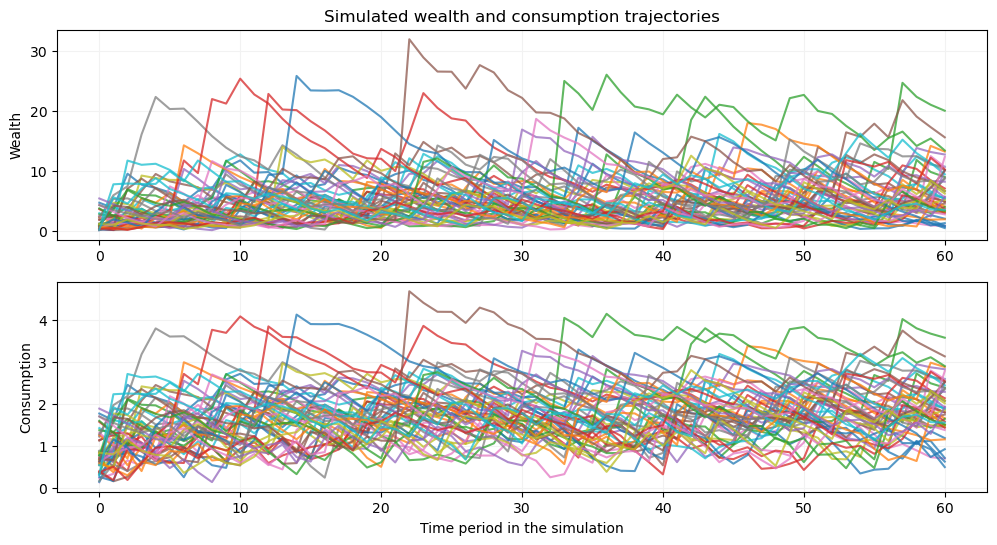

array([[ 3.67520676,  6.01126752,  5.48359527,  4.73566445,  3.94528001,
         2.68707576,  2.2409732 ,  1.58462644,  2.65391477,  2.05406881],
       [ 8.73164469,  8.25236846,  6.8429512 ,  6.50466457,  6.32685921,
         5.83043101,  4.95878164,  3.96496481,  3.10852263,  3.26440986],
       [10.79696896,  9.07820096,  7.93595483,  6.63814936,  6.47208754,
         5.00055684,  3.58850347, 11.86316994,  9.85261267,  9.00350542],
       [ 7.10959904,  7.07199726,  5.50969709,  4.31862488,  5.12652916,
         3.68274771,  3.98311421,  4.32498102,  5.53262199,  4.90405323],
       [ 9.17601311,  9.09023265,  8.86132643,  9.05873096,  8.03212218,
         6.98890665,  5.78121815,  5.24486334,  4.0216068 , 10.20982709],
       [14.02532487, 12.58521942, 11.17332631,  9.31539358,  7.72850771,
         7.97806809,  6.4974273 ,  4.82932396,  4.03428254,  4.57922106],
       [ 3.82078627,  2.36501117,  1.86142354,  3.49325559,  2.37189796,
         1.36536132,  1.60308447,  1.25199602

In [59]:
# For this exercise the DATA will be given by
model = deaton(beta=0.92,Mbar=50,ngrid=100)
model.solve_egm()
np.random.seed(14) # fix seed for initial draws
init_wealth = np.exp(np.random.randn(50)) # draw initial wealth
np.random.seed(15) # fix seed for simulations
data = model.simulator(init_wealth=init_wealth,T=60)
data_wealth = data['M']
data_wealth[:,-10:]

In [60]:
def moments_function(data,tail=10):
    '''Computes two moments: mean and std dev from
       the tail of the given time series (from last axis)
       Returns two vectors with moments computed at individual level
    '''
    d = data.ndim-1  # last dimension
    mean = np.mean(data[:,-tail:],axis=d)
    std = np.std(data[:,-tail:],axis=d)
    return mean, std

In [61]:
data_moment1, data_moment2 = moments_function(data_wealth)
data_moment1

array([ 3.5071673 ,  5.77855981,  8.022971  ,  5.15639656,  7.64648474,
        8.27460948,  1.99179399,  5.05885577,  2.62086604,  6.37565976,
        1.1920514 ,  6.54683236,  2.47215023,  2.73553966,  3.89960044,
        4.64724549,  6.60379385,  4.62225155,  2.41792429,  9.03348218,
        1.98095055,  4.05405986, 12.74298527,  7.11958397,  7.58063489,
       15.41579014,  7.05087123,  5.5894658 ,  5.08917971,  7.30041023,
        2.23387677, 10.34747218, 16.16890398,  2.68018702, 10.21664508,
        9.57456986,  2.72574949, 11.93900634,  4.71831672, 11.83079947,
        5.47536841,  2.47154378,  2.86561779,  9.10936509,  3.52595114,
        5.74202936,  6.61053222,  8.51645197,  4.57136386,  3.79709393])

In [62]:
# Data moments
print('Number of observed individuals: ',data_wealth.shape[0],sep=' ')
print('Number of observed time periods:',data_wealth.shape[1],sep=' ')
data_moment1, data_moment2 = moments_function(data_wealth)  # data moments on individual level (of observed sample)
data_moment1_mean, data_moment1_std = np.mean(data_moment1), np.std(data_moment1)  # descriptive stats for empirical moments
data_moment2_mean, data_moment2_std = np.mean(data_moment2), np.std(data_moment2)
print(f'Moment 1 (mean wealth), mean and std.dev. over data sample  : {data_moment1_mean:.5f} ({data_moment1_std:.5f})')
print(f'Moment 2 (std of wealth), mean and std.dev. over data sample: {data_moment2_mean:.5f} ({data_moment2_std:.5f})')
data_moments_vec = np.array([data_moment1_mean,data_moment2_mean])  # vector of aggregated moments

Number of observed individuals:  50
Number of observed time periods: 61
Moment 1 (mean wealth), mean and std.dev. over data sample  : 6.15298 (3.45446)
Moment 2 (std of wealth), mean and std.dev. over data sample: 2.07730 (1.23501)


In [64]:
# MSM estimation exercise
model = deaton(beta=0.95,Mbar=50,ngrid=100)  # init the model
np.random.seed(214)                          # fix for initial wealth
init_wealth = np.exp(np.random.randn(250))   # draw initial wealth

def moment_conditions(theta,data_moments,seed=215):
    '''Moment conditions for MSM estimator,
       Inputs: parameter vector + vector of aggregated data moments
       Computed at the individual level.
       Random number generator seed fixed by default.
    '''
    model.beta = theta
    np.random.seed(seed) # must be fixed between calls!
    model.solve_egm(maxiter=1000)
    simdata = model.simulator(init_wealth=init_wealth,T=60,plot=False)
    # compute simulated moments
    sim_moment1, sim_moment2 = moments_function(simdata['M'])
    return sim_moment1 - data_moments[0], sim_moment2 - data_moments[1]

In [66]:
from scipy.optimize import minimize_scalar
from scipy.misc import derivative

def run_MSM(data_moments = data_moments_vec,                 # vector of data moments
            moment_conditions_function = moment_conditions,  # moment conditions generator
            W = None,                                        # weighting matrix
            bracket = [.85,.95],                             # approximate limits for the parameters
            plot = True):
    '''Run the MSM estimation
       Returns estimates and std.err. of estimates
    '''

    def mean_conditions(theta):
        '''Means of the moment conditions returned as a vector'''
        moms = moment_conditions_function(theta,data_moments)  # return a tuple
        moms = np.array(moms)  # convert to array, moments in axis=0, indiv in axis=1
        return np.mean(moms,axis=1)  # vector of means of moment conditions

    def criterion(theta,W):
        '''Criterion function for MSM estimator'''
        err = mean_conditions(theta)
        return err @ W @ err.T

    if W is None:
        # default weighting matrix = identity
        check = moment_conditions_function(1.0,data_moments)  # check how many moments
        W = np.eye(len(check))

    # minimize the criterion function
    res = minimize_scalar(criterion,method='Brent',args=(W),bracket=bracket,tol=1e-8)
    if not res.success:
        raise RuntimeError('Bellman continuous failed to find optimal consumption')
    theta_hat = res.x  # estimate

    # find out how many simulations were used
    moms = moment_conditions_function(theta_hat,data_moments)
    nsims = len(moms[0])  # will use in place of tau, assuming nobs=1 in the data

    D = derivative(mean_conditions,theta_hat,dx=1e-10)  # Jacobian of moment conditions
    DWD = D @ W @ D
    if np.isscalar(DWD):
        Sigma_hat = (1+1/nsims)/( DWD)  # using simple formula
        stderr = np.sqrt(Sigma_hat)
    else:
        Sigma_hat = (1+1/nsims)*np.linalg.inv( DWD)  # using simple formula
        stderr = np.sqrt(np.diag(Sigma_hat))
    CI = [theta_hat-1.96*stderr,theta_hat+1.96*stderr]  # 1.96 confidence interval

    print(f'MSM estimate       : {theta_hat:1.5f}')
    print(f'StdErr of estimate : {stderr:1.5f}')
    print(f'Confidence interval: ({CI[0]:1.5f},{CI[1]:1.5f})')

    if plot:
        # Plot criterion for visual inspection
        xd = np.linspace(bracket[0],bracket[1],50)
        yd = [criterion(b,W) for b in xd]
        fig,ax = plt.subplots(figsize=(12,8))
        ax.plot(xd,yd,color='r',label='MSM criterion function')
        y1,y2 = ax.get_ylim()
        ax.plot([theta_hat,theta_hat],[y1,y2],color='grey',label='MSM estimate')
        ax.fill_between(x=CI,y1=y1,y2=y2,color='grey',alpha=0.25,label='1.96 confidence interval')
        ax.legend()
        ax.set_title('Criterion function and MSM estimate');

    return theta_hat

MSM estimate       : 0.92092
StdErr of estimate : 0.01054
Confidence interval: (0.90027,0.94157)


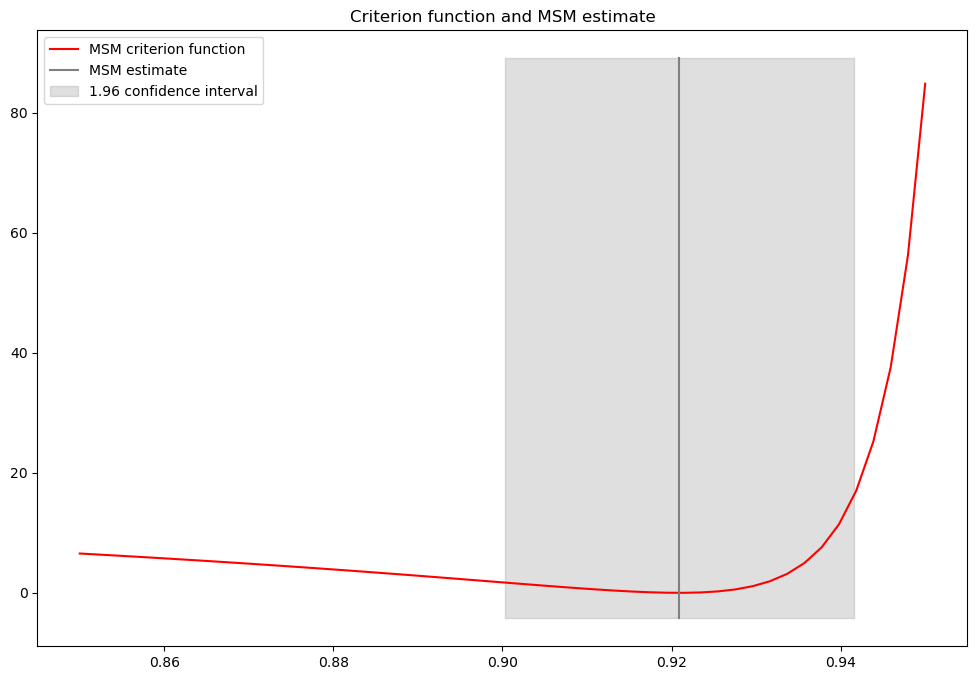

In [67]:
beta_hat = run_MSM()  # initial run with default identity weighting matrix

MSM estimate       : 0.92112
StdErr of estimate : 0.03534
Confidence interval: (0.85187,0.99038)


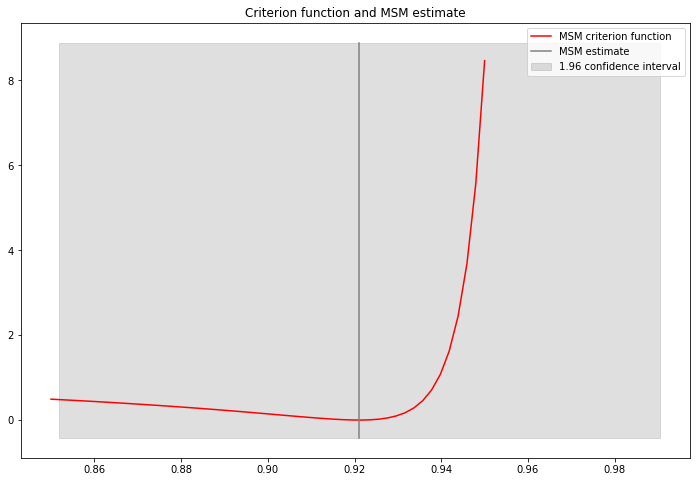

In [12]:
# Second stage MSM
moms = moment_conditions(beta_hat,data_moments_vec,seed=515)  # simulate a separate set of moment conditions
S = np.cov(np.array(moms))                                    # variance-covariance matrix of moment conditions
W1 = np.linalg.inv(S)                                         # unpdated weighting matrix
beta_hat_2 = run_MSM(W=W1)

### Further learning resources

- 📖 Adda Cooper “Dynamic Economics” pp. 87-89  
- Notebook by Richard W Evans on MSM [https://notes.quantecon.org/submission/5b3db2ceb9eab00015b89f93](https://notes.quantecon.org/submission/5b3db2ceb9eab00015b89f93)  
- Example of MSM application to model the effects of the Australian age pension [https://doi.org/10.1016/j.jeconom.2020.01.023](https://doi.org/10.1016/j.jeconom.2020.01.023)  
- Keane’s lecture on structural estimation at BFI at the University of Chicago [https://youtu.be/0hazaPBAYWE](https://youtu.be/0hazaPBAYWE)  
- Popper’s falsification principle in under 2 min [https://youtu.be/wf-sGqBsWv4](https://youtu.be/wf-sGqBsWv4)  